<a href="https://colab.research.google.com/github/jonnyderme/Neural-Networks-and-Deep-Learning/blob/main/Assignment_1_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 1 -- Νευρωνικά Δικτυα**
Δεϊρμεντζόγλου Ιωάννης

# **Load and Preprocess the dataset -- Cifar 10**

Οι απαραιτητες βιβλιοθήκες που θα χρησιμοποιηθούν παρακάτω

In [ ]:
import tensorflow

# Import CIFAR-10 dataset
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils
from tensorflow.keras import models,layers
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
import tensorflow.keras.backend as K

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score


import numpy as np
import time

from matplotlib import pyplot as plt

## **Preprocess the dataset**
  Φορτωση των train και test sets για την cifar 10 . Στην συνεχεια , οι εικόνες μετατραπηκαν σε μονοδιάστατο πίνακα με τα features = 32x32x3 = 3072 (RGB εικονες) .

In [ ]:
#Load data
(XTrain, yTrain), (XTest, yTest) = cifar10.load_data()

unique, counts = np.unique(yTrain, return_counts=True)
print("Training Labels: ", dict(zip(unique, counts)))
unique, counts = np.unique(yTest, return_counts=True)
print("Testing Labels: ", dict(zip(unique, counts)))

# Get the number of features in the test set
numFeatures = XTrain.shape[1]*XTrain.shape[2]*XTrain.shape[3]
print("Number of features in CIFAR-10:", numFeatures)

# Get the number of classes in the test set
numClasses = len(set(yTest.flatten()))
print("Number of classes in CIFAR-10:", numClasses)


print("Train set shape : ", XTrain.shape)
print("Labels for the train set shape :", yTrain.shape)
print("Test set shape :", XTest.shape)
print("Labels for the test set shape :", yTest.shape)

#Convert to float32
XTrain, XTest = np.array(XTrain, dtype=np.float32), np.array(XTest, dtype=np.float32)

#Flatten image to 1-D vector
XTrain = XTrain.reshape([-1, numFeatures])
XTest  = XTest.reshape([-1, numFeatures])

# Keep not normalized Train and Test set
XTrainNotScaled = XTrain
XTestNotScaled = XTest

#Normalize to [0,1]
XTrain = XTrain/XTrain.max()
XTest =  XTest/XTest.max()

#Labels without the one-hot encoding (needed in Nearest Centroid)
yTrainLabels = yTrain
yTestLabels = yTest

#One-hot encoding
yTrain, yTest = utils.to_categorical(yTrain, numClasses), utils.to_categorical(yTest, numClasses)



170498071/170498071 [==============================] - 3s 0us/step
Training Labels:  {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Testing Labels:  {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
Number of features in CIFAR-10: 3072
Number of classes in CIFAR-10: 10
Train set shape :  (50000, 32, 32, 3)
Labels for the train set shape : (50000, 1)
Test set shape : (10000, 32, 32, 3)
Labels for the test set shape : (10000, 1)


## **F1 score Calculation Function**

In [ ]:
def f1Score(yTrue, yPrediction):
    truePositives = K.sum(K.round(K.clip(yTrue * yPrediction, 0, 1)))
    predictedPositives = K.sum(K.round(K.clip(yPrediction, 0, 1)))
    possiblePositives = K.sum(K.round(K.clip(yTrue, 0, 1)))

    # Calculate recall
    recall = truePositives / (possiblePositives+K.epsilon())
    # Calculate precision
    precision = truePositives / (predictedPositives+K.epsilon())

    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# **PCA : Principle Component Analysis**

Παρακατω με αναλυση κυριων συνιστωσων μειωνεται ο αριθμος των features τετοιος ωστε να διατηρειται το 90%  ή αντιστοιχα το 95 % της διακύμανσης των αρχικων δεδομενων . Γενικά , στόχος είναι να δημιουργήσουμε  νέα features που προκύπτουν από το αρχικό σύνολο(3072 για την cifar 10)  με σκοπό να διατηρηθεί όσο περισσοτερη πληροφορία γίνεται σε πολύ μικρότερο αριθμό features.

In [ ]:
pca = PCA(n_components=0.9).fit(XTrain)
XTrainPCA = pca.transform(XTrain)
XTestPCA = pca.transform(XTest)

print('Number of features after PCA :',XTrainPCA.shape[1])

Number of features after PCA : 99


In [ ]:
pca2 = PCA(n_components=0.95).fit(XTrain)
XTrainPCA2 = pca2.transform(XTrain)
XTestPCA2 = pca2.transform(XTest)

print('Number of features after PCA :',XTrainPCA2.shape[1])

Number of features after PCA : 217


# **ΚNN and Nearest Centroid classification**


##  **KNN Classification**

### **Nearest Neighbor with k=1 neighbor**

In [ ]:
knn1Neighbor = KNeighborsClassifier(n_neighbors=1, p=2)   # use Euclidean distance metric

start = time.time()

knn1Neighbor.fit(XTrainPCA, yTrain)

end = time.time()

print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

score = knn1Neighbor.score(XTestPCA,yTest)
yPred = knn1Neighbor.predict(XTestPCA)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the 1-NN classifier accuracy is: {:.4f}".format(score))
print("For the 1-NN classifier, F1 score is: {:.4f}".format(f1))

Training time: 0.060 seconds

Testing time: 23.253 seconds

For the 1-NN classifier accuracy is: 0.3858
For the 1-NN classifier, F1 score is: 0.3851


### **Nearest Neighbor with k=3 neighbors**

In [ ]:
knn3Neighbors = KNeighborsClassifier(n_neighbors=3, p=2)      # use Euclidean distance metric

start = time.time()

knn3Neighbors.fit(XTrainPCA, yTrain)

end = time.time()
print("Training time: {} seconds\n".format(end-start))

start = time.time()

score = knn3Neighbors.score(XTestPCA, yTest)
yPred = knn3Neighbors.predict(XTestPCA)
f1 = f1_score(yTest, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the 3-NN classifier accuracy is: {:.4f}".format(score))
print("For the 3-NN classifier, F1 score is: {:.4f}".format(f1))

Training time: 0.04543471336364746 seconds

Testing time: 23.823 seconds

For the 3-NN classifier accuracy is: 0.3066
For the 3-NN classifier, F1 score is: 0.3569


## **Nearest Centroid Classification**

**Nearest Centroid Classifier with Euclidean Distance metric**

In [ ]:
nearCentroid = NearestCentroid(metric='euclidean')

start = time.time()

nearCentroid.fit(XTrainPCA, yTrainLabels.ravel())

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

scoreNearCentroid = nearCentroid.score(XTestPCA,yTestLabels.ravel())
yPred = nearCentroid.predict(XTestPCA)
f1 = f1_score(yTestLabels, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the Nearest Centroid classifier accuracy is: {:.4f}".format(score))
print("For the Nearest Centroid classifier, F1 score is: {:.4f}".format(f1))

Training time: 0.022 seconds

Testing time: 0.028 seconds

For the Nearest Centroid classifier accuracy is: 0.3858
For the Nearest Centroid classifier, F1 score is: 0.2532


**Nearest Centroid Classifier with Manhattan Distance metric**

In [ ]:
nearCentroid = NearestCentroid(metric='manhattan')  # use manhattan distance metric

start = time.time()

nearCentroid.fit(XTrainPCA, yTrainLabels.ravel())

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

start = time.time()

scoreNearCentroid = nearCentroid.score(XTestPCA,yTestLabels.ravel())
yPred = nearCentroid.predict(XTestPCA)
f1 = f1_score(yTestLabels, yPred,average='weighted')  # Calculate F1 score

end = time.time()
print("Testing time: {:.3f} seconds\n".format(end-start))

print("For the Nearest Centroid classifier accuracy is: {:.4f}".format(score))
print("For the Nearest Centroid classifier, F1 score is: {:.4f}".format(f1))

Training time: 0.730 seconds

Testing time: 0.176 seconds

For the Nearest Centroid classifier accuracy is: 0.3858
For the Nearest Centroid classifier, F1 score is: 0.2734


# **Δημιουργια βασικου μοντελου**


##**Αρχικο Μοντελο**
Για το βασικο μοντελο χρησιμοποιηθηκε η απλη εκδοχη ενος δικτυου με 2 στρωματα και 512 νευρωνες για το ενδιαμεσο layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1578506 (6.02 MB)
Trainable params: 1578506 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
313/313 [==============================] - 13s 40ms/step - loss: 2.3128 - accuracy: 0.2536 - f1Score: 0.2739 - val_loss: 1.9009 - val_accuracy: 0.3196 - val_f1Score: 0.2988
Epoch 2/10
313/313 [==============================] - 10s 32ms/step - loss: 1.8354 - accuracy: 0.3431 - f1Score: 0.3180 - val_loss: 1.8773 - val_accuracy: 0.3268 - val_f1Score: 0.3124
Epoch 3/10
313/313 [==========================

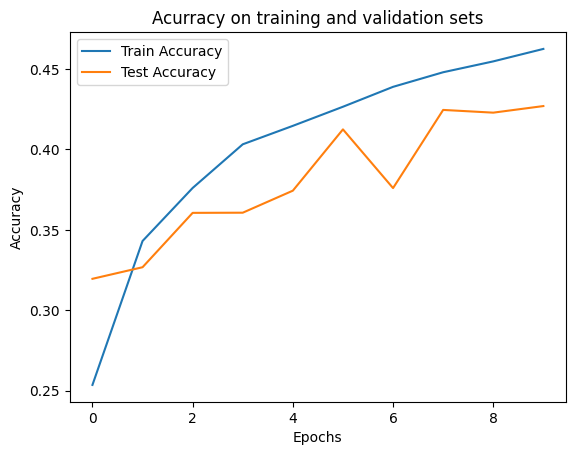

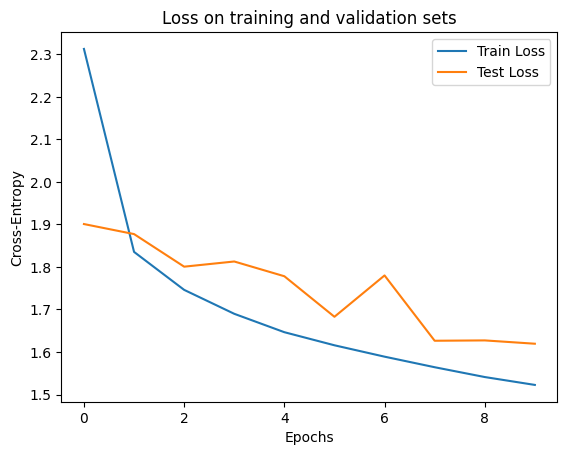

313/313 [==============================] - 2s 6ms/step - loss: 1.5890 - accuracy: 0.4368 - f1Score: 0.3480
Test accuracy: 0.4368
Test F1 Score: 0.3480
313/313 [==============================] - 2s 6ms/step
Printing examples of correct classification:


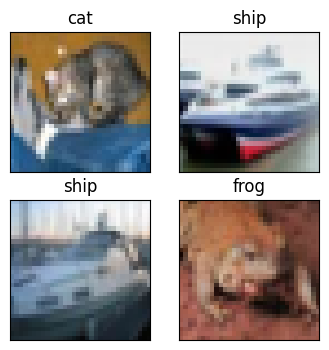

Printing examples of false classification:


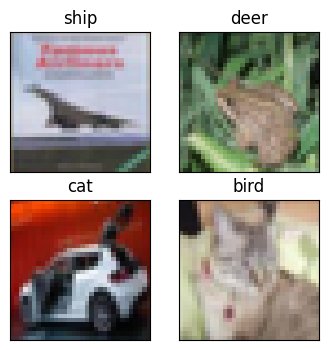

In [ ]:
baseModel1 = models.Sequential()

baseModel1.add(layers.Dense(512, input_shape=(numFeatures,), activation='relu'))
baseModel1.add(layers.Dense(10))

baseModel1.summary()

baseModel1.compile(loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy' , f1Score])

start = time.time()

#Train model
history = baseModel1.fit(XTrain, yTrain, epochs=10, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Calculate F1 score
score = baseModel1.evaluate(XTest, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))
print('Test F1 Score: {:.4f}'.format(score[2]))

prediction = baseModel1.predict(XTest)
yPred = np.argmax(prediction, axis=1) #get predicted class
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Print examples of correct and false classification
XTestR = XTest.reshape(XTest.shape[0] , 32 ,32,3)

print('Printing examples of correct classification:')
printed = 0
fig = plt.figure(figsize=(4,4))
for i in range (0, yTest.shape[0]):
    if yTestLabels[i] == yPred[i]:
       ax = fig.add_subplot(2, 2, printed + 1, xticks=[], yticks=[])
       ax.title.set_text(labels[yPred[i]])
       ax.imshow((XTestR[i, :]*XTrainNotScaled.max()).astype(int))
       printed += 1
    if printed == 4:
       printed = 0
       break
plt.show()

print('Printing examples of false classification:')
fig2 = plt.figure(figsize=(4,4))
for i in range (0, yTest.shape[0]):
    if yTestLabels[i] !=  yPred[i]:
     ax2 = fig2.add_subplot(2, 2, printed + 1, xticks=[], yticks=[])
     ax2.title.set_text(labels[yPred[i]])
     ax2.imshow((XTestR[i, :]*XTrainNotScaled.max()).astype(int))
     printed += 1
     if printed == 4:
        break
plt.show()



## **Different Learning rates**

Μοντελο 1 με 2 layers και Learning Rate = 0.001

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               1573376   
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1841162 (7.02 MB)
Trainable params: 1841162 (7.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
313/313 [==============================] - 18s 56ms/step - loss: 1.9132 - accuracy: 0.3148 - f1Score: 0.2931 - val_loss: 1.7698 - val_accuracy: 0.3754 - val_f1Score: 0.3099
Epoch 2/50
313/313 [==============================] - 16s 50ms/step - loss: 1.6797 - accuracy: 0

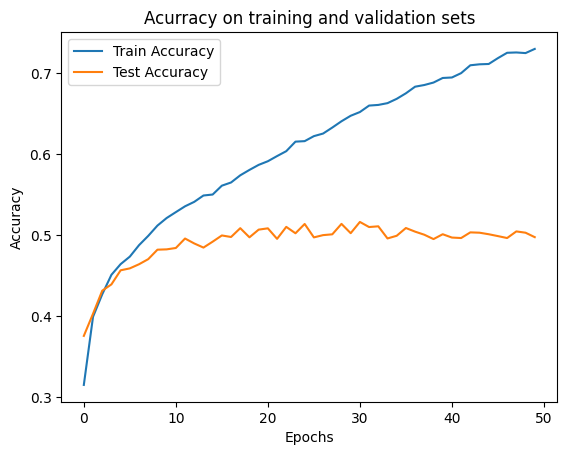

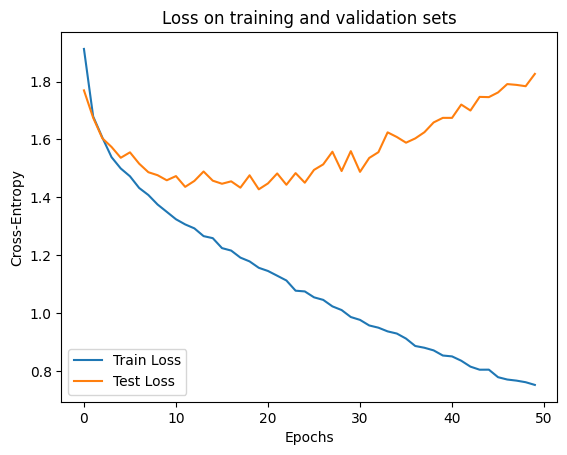

313/313 [==============================] - 3s 10ms/step - loss: 1.7606 - accuracy: 0.4990 - f1Score: 0.3939
Test accuracy: 0.4990
Test F1 Score: 0.3939
313/313 [==============================] - 2s 6ms/step
Printing examples of correct classification:


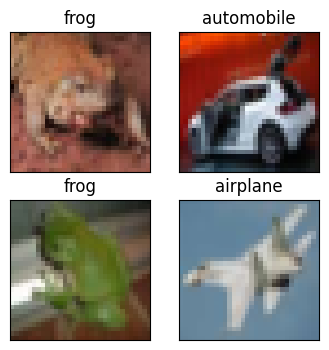

Printing examples of false classification:


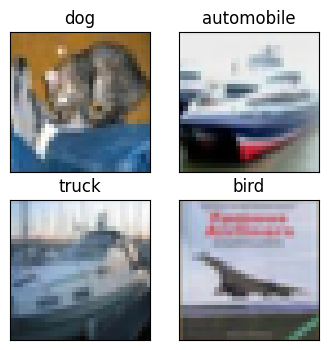

In [ ]:
Model1 = models.Sequential()

Model1.add(layers.Dense(512, input_shape=(XTrain[1].shape), activation='relu'))
Model1.add(layers.Dense(512, activation='relu'))
Model1.add(layers.Dense(10))

Model1.summary()

Model1.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy' , f1Score])

start = time.time()

#Train model
history = Model1.fit(XTrainPCA, yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))


plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

score = Model1.evaluate(XTest, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))
print('Test F1 Score: {:.4f}'.format(score[2]))


prediction = Model1.predict(XTest)
yPred = np.argmax(prediction, axis=1) #get predicted class
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Print examples of correct and false classification
XTestR = XTest.reshape(XTest.shape[0] , 32 ,32,3)

print('Printing examples of correct classification:')
printed = 0
fig = plt.figure(figsize=(4,4))
for i in range (0, yTest.shape[0]):
    if yTestLabels[i] == yPred[i]:
       ax = fig.add_subplot(2, 2, printed + 1, xticks=[], yticks=[])
       ax.title.set_text(labels[yPred[i]])
       ax.imshow((XTestR[i, :]*XTrainNotScaled.max()).astype(int))
       printed += 1
    if printed == 4:
       printed = 0
       break
plt.show()

print('Printing examples of false classification:')
fig2 = plt.figure(figsize=(4,4))
for i in range (0, yTest.shape[0]):
    if yTestLabels[i] !=  yPred[i]:
     ax2 = fig2.add_subplot(2, 2, printed + 1, xticks=[], yticks=[])
     ax2.title.set_text(labels[yPred[i]])
     ax2.imshow((XTestR[i, :]*XTrainNotScaled.max()).astype(int))
     printed += 1
     if printed == 4:
        break
plt.show()


Μοντελο 1 με 2 layers και Learning Rate = 0.01

In [ ]:
Model1.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.01),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy' , f1Score])

start = time.time()

#Train model
history = Model1.fit(XTrain, yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3F} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

score = Model1.evaluate(XTestPCA, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))
print('Test F1 Score: {:.4f}'.format(score[2]))



## **Change optimizer use SGD**

In [ ]:
Model1.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy' , f1Score])

start = time.time()

#Train model
history = Model1.fit(XTrain, yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

score = Model1.evaluate(XTest, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))
print('Test F1 Score: {:.4f}'.format(score[2]))



## **Add one more hidden Layer**

In [ ]:
Model2 = models.Sequential()

Model2.add(layers.Dense(512, input_shape=(XTrain[1].shape), activation='relu'))
Model2.add(layers.Dense(512, activation='relu'))
Model2.add(layers.Dense(256, activation='relu'))
Model2.add(layers.Dense(10))

Model2.summary()

Model2.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy' , f1Score])
start = time.time()

#Train model
history = Model2.fit(XTrain, yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

score = Model2.evaluate(XTest, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))
print('Test F1 Score: {:.4f}'.format(score[2]))

# **Weight Initialization**

Για την αρχικοποιηση των βαρών χρησιμοποιηθηκε η μέθοδος ΗeNormal() , η οποια προτεινεται στις περιπτώσεις , οπου ως συνάρτηση ενεργοποίσης χρησιμοποιείται η ReLu.

In [ ]:
Model3 = models.Sequential()

Model3.add(layers.Dense(512,input_shape=XTrainPCA[1].shape,activation='relu',kernel_initializer =initializers.HeNormal))

Model3.add(layers.Dense(512, activation='relu',
                        kernel_initializer=initializers.HeNormal()))

Model3.add(layers.Dense(10))

Model3.summary()

Model3.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy',f1Score])

start = time.time()

#Train model
history = Model3.fit(XTrainPCA , yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

score = Model3.evaluate(XTestPCA, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))

# **Regularization to avoid Overfitting**

## **Dropout**

Παρακάτω χρησιμοποιείται η τεχνική του dropout για την αποφυγή του overfitting. H συγκεκριμένη τεχνική ουσιαστικά απενεργοποιεί τυχαία
ένα κομμάτι των νευρώνων με πιθανότητα p ενός πλήρως συνδεδεμένου επιπέδου, αναγκάζοντας έτσι κάθε νευρώνα να μην επηρεάζεται από τους άλλους του ίδιου επιπέδου και να εντοπίζει χρήσιμη πληροφορία από το προηγούμενο επίπεδο.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               51200     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 10)                5130      
                                                                 
Total params: 318986 (1.22 MB)
Trainable params: 318986 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
313/313

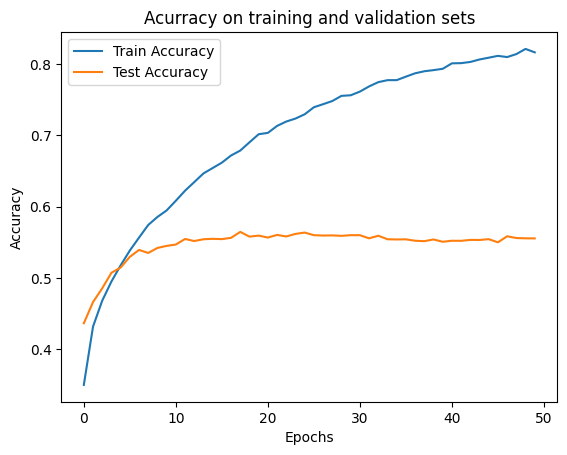

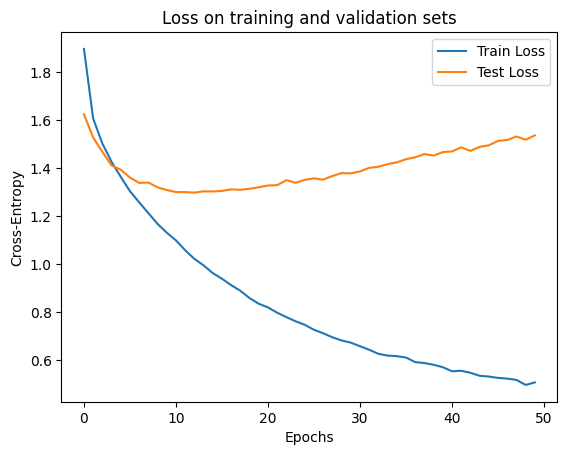

313/313 [==============================] - 1s 3ms/step - loss: 1.5033 - accuracy: 0.5529 - f1Score: 0.4456
Test accuracy: 0.5529


In [ ]:
Model5 = models.Sequential()

Model5.add(layers.Dense(512, input_shape=(XTrainPCA[1].shape), activation='relu',
                        kernel_initializer=initializers.HeNormal()))
Model5.add(layers.Dropout(0.4))

Model5.add(layers.Dense(512, activation='relu',
                        kernel_initializer=initializers.HeNormal()))
Model5.add(layers.Dropout(0.4))

Model5.add(layers.Dense(10))

Model5.summary()

Model5.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy' , f1Score])

start = time.time()

#Train model
history = Model5.fit(XTrainPCA, yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

score = Model5.evaluate(XTestPCA, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))

## **Batch Normalization**
H τεχνική batch normalization ουσιαστικά λειτουργεί κανονικοποιώντας τις εξόδους κάθε επιπέδου πριν την εφαρμογή της συνάρτησης ενεργοποίησης. Αυτό επιτρέπει στο μοντέλο να μάθει πιο γρήγορα και να αποφύγει το πρόβλημα της αστάθειας που οφείλεται σε ακραίες τιμές εισόδου.

In [ ]:
Model5 = models.Sequential()

Model5.add(layers.Dense(512, input_shape=(XTrainPCA[1].shape), activation='relu',
                        kernel_initializer=initializers.HeNormal()))
Model5.add(layers.BatchNormalization())

Model5.add(layers.Dense(512, activation='relu',
                        kernel_initializer=initializers.HeNormal()))
Model5.add(layers.BatchNormalization())

Model5.add(layers.Dense(10))

Model5.summary()

Model5.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy' , f1Score])

start = time.time()

#Train model
history = Model5.fit(XTrainPCA, yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


score = Model5.evaluate(XTestPCA, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))
print('Test F1 Score: {:.4f}'.format(score[2]))

## **Early Stopping**
Με βάση την επίδοση του μοντέλου πάνω στο validation set μπορεί να ληφθεί απόφαση για πρόωρο τερματισμό της εκπαίδευσης ώστε να αποφευχθεί η περίπτωση του overfitting. Η απόφαση λαμβάνεται όταν η συνάρτηση κόστους δεν έχει βελτιωθεί (δηλαδή βρεθεί σε νέο ελάχιστο) στη διάρκεια ενός συγκεκριμένου αριθμού εποχών εκπαίδευσης.

In [ ]:
Model5 = models.Sequential()

Model5.add(layers.Dense(512, input_shape=(XTrainPCA[1].shape), activation='relu',
                        kernel_initializer=initializers.HeNormal()))

Model5.add(layers.Dense(512, activation='relu',
                        kernel_initializer=initializers.HeNormal()))

Model5.add(layers.Dense(10))

Model5.summary()

earlyStopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience = 20,verbose=1)


Model5.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy', f1Score])

start = time.time()

#Train model
history = Model5.fit(XTrainPCA, yTrain, epochs=50, batch_size=128, validation_split=0.2, callbacks=[earlyStopping], verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


score = Model5.evaluate(XTestPCA, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))
print('Test F1 Score: {:.4f}'.format(score[2]))

## **Lasso--L1 Regularization**

In [ ]:
Model3 = models.Sequential()

Model3.add(layers.Dense(512,input_shape=XTrainPCA[1].shape,activation='relu',kernel_initializer =initializers.HeNormal,kernel_regularizer=regularizers.l1(0.001),))

Model3.add(layers.Dense(512, activation='relu', kernel_initializer=initializers.HeNormal() , kernel_regularizer=regularizers.l1(0.001)))

Model3.add(layers.Dense(10))

Model3.summary()

Model3.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy' , f1Score])

start = time.time()

#Train model
history = Model3.fit(XTrainPCA , yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


score = Model3.evaluate(XTestPCA, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))
print('Test F1 Score: {:.4f}'.format(score[2]))

# **Hyper-Parameter Tuning**

In [ ]:
!pip install tensorflow-addons
!pip install keras-tuner --upgrade


In [ ]:
import tensorflow_addons as tfa
import keras_tuner as kt

In [ ]:
def buildModel(hParam):
    model = models.Sequential()

    # Probability p of dropout
    DroboutProb = hParam.Choice('p', values = [ 0.2, 0.3, 0.4])

    #Number of neurons in the 1st hidden layer
    unitsHL1 = hParam.Choice('units_First_Hidden_Layer', values = [2048, 1024, 512])
    model.add(layers.Dense(units = unitsHL1,input_shape=(XTrainPCA[1].shape), activation = 'relu',
                             kernel_initializer = initializers.HeNormal()))

    model.add(layers.Dropout(rate=DroboutProb))

    #Number of neurons in the 2nd layer
    unitsHL2 = hParam.Choice('units_Second_Hidden_Layer', values = [1024, 512,256])
    model.add(layers.Dense(units = unitsHL2, activation = 'relu',
                             kernel_initializer = initializers.HeNormal()))

    model.add(layers.Dropout(rate=DroboutProb))

    #Output layer
    model.add(layers.Dense(numClasses, kernel_initializer = initializers.HeNormal()))

    #Learning rate of Adam to be learned by the hypermodel
    LearningRate = hParam.Choice('learning_rate', values = [1e-3 ,1e-2])

    #Build model
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate = LearningRate),
                    loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=[f1Score,'accuracy'])

    return model

In [ ]:
# Set up tuner
tuner = kt.RandomSearch(buildModel, objective=kt.Objective('val_accuracy', direction = 'max'), max_trials= 40, executions_per_trial=2, overwrite=True)

start = time.time()

tuner.search(XTrainPCA,yTrain, epochs=25, batch_size=128, validation_split=0.2)

end = time.time()
print("Total time: {:.3f} seconds\n".format(end-start))


#Get the optimal hyperparameters
bestHyperParameters= tuner.get_best_hyperparameters(num_trials=1)[0]

print("Optimal number of neurons in 1st layer: {}".format(bestHyperParameters.get('units_First_Hidden_Layer')))
print("Optimal number of neurons in 2nd layer: {}".format(bestHyperParameters.get('units_Second_Hidden_Layer')))
print("Optimal value of p for dropout: {}".format(bestHyperParameters.get('p')))
print("Optimal value of learning rate: {}".format(bestHyperParameters.get('learning_rate')))

Trial 40 Complete [00h 23m 54s]
val_accuracy: 0.5676999986171722

Best val_accuracy So Far: 0.5676999986171722
Total elapsed time: 07h 12m 22s
Total time: 25941.732 seconds

Optimal number of neurons in 1st layer: 2048
Optimal number of neurons in 2nd layer: 1024
Optimal value of p for dropout: 0.4
Optimal value of learning rate: 0.001


## **Build Optimal Model**
Κατασκευαζεται το δικτυο με τις ιδανικες παραμετρους που βγηκαν απο το hyparameter tuning .

In [ ]:
#Build model
optimalModel = tuner.hypermodel.build(bestHyperParameters)

start = time.time()

#Train model
history = optimalModel.fit(XTrainPCA, yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


score = optimalModel.evaluate(XTestPCA, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))
print('Test F1 Score: {:.4f}'.format(score[2]))

#Predictions
prediction = optimalModel.predict(XTest, verbose=1)
yPred = np.argmax(prediction, axis=1) #get predicted class
labels = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#Create and display confusion matrix
M = confusion_matrix(yTestLabels, yPred)

disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show

#accuracy, precision, recall and f1-score
print(classification_report(yTestLabels, yPred))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2048)              204800    
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                10250     
                                                                 
Total params: 2313226 (8.82 MB)
Trainable params: 2313226 (8.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
313/3

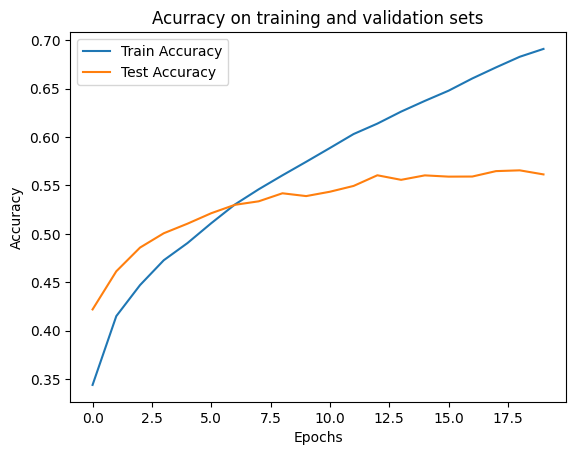

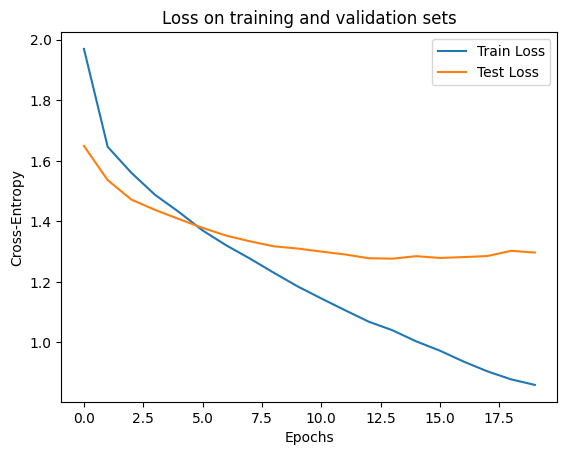

313/313 [==============================] - 2s 7ms/step - loss: 1.2752 - accuracy: 0.5611 - f1Score: 0.4117
Test accuracy: 0.5611


In [ ]:
optimalModel = models.Sequential()

optimalModel.add(layers.Dense(2048, input_shape=(XTrainPCA[1].shape), activation='relu',
                        kernel_initializer=initializers.HeNormal()))
optimalModel.add(layers.Dropout(0.4))

optimalModel.add(layers.Dense(1024, activation='relu',
                        kernel_initializer=initializers.HeNormal()))
optimalModel.add(layers.Dropout(0.4))

optimalModel.add(layers.Dense(10))

optimalModel.summary()

optimalModel.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy' , f1Score])

start = time.time()

#Train model
history = optimalModel.fit(XTrainPCA, yTrain, epochs=20, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

score = optimalModel.evaluate(XTestPCA, yTest)
print('Test accuracy: {:.4f}'.format(score[1]))



313/313 [==============================] - 4s 12ms/step
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1000
           1       0.67      0.69      0.68      1000
           2       0.46      0.44      0.45      1000
           3       0.38      0.41      0.39      1000
           4       0.50      0.48      0.49      1000
           5       0.45      0.45      0.45      1000
           6       0.60      0.67      0.63      1000
           7       0.67      0.61      0.64      1000
           8       0.71      0.68      0.70      1000
           9       0.61      0.62      0.61      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000



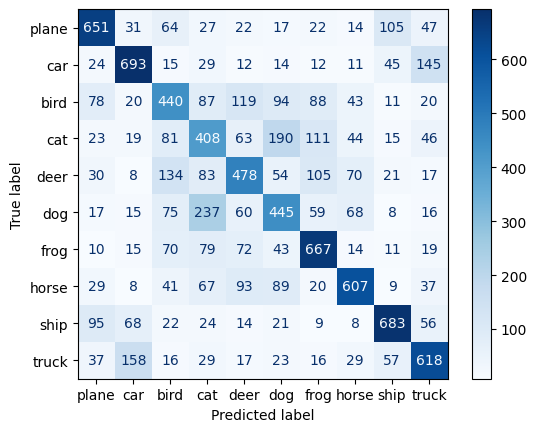

In [ ]:
#Predictions
prediction = Model5.predict(XTestPCA, verbose=1)
yPred = np.argmax(prediction, axis=1) #get predicted class
labels = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#Create and display confusion matrix
M = confusion_matrix(yTestLabels, yPred)

disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show

#accuracy, precision, recall and f1-score
print(classification_report(yTestLabels, yPred))

# **Convolutional Neural Network**

In [ ]:
import cv2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold



## **Preprocess the data**

In [ ]:
#Load data
(XTrain, yTrain), (XTest, yTest) = cifar10.load_data()

unique, counts = np.unique(yTrain, return_counts=True)
print("Training Labels: ", dict(zip(unique, counts)))
unique, counts = np.unique(yTest, return_counts=True)
print("Testing Labels: ", dict(zip(unique, counts)))

# Get the number of features in the test set
numFeatures = XTrain.shape[1]*XTrain.shape[2]*XTrain.shape[3]
print("Number of features in CIFAR-10:", numFeatures)

# Get the number of classes in the test set
numClasses = len(set(yTest.flatten()))
print("Number of classes in CIFAR-10:", numClasses)


print("Train set shape : ", XTrain.shape)
print("Labels for the train set shape :", yTrain.shape)
print("Test set shape :", XTest.shape)
print("Labels for the test set shape :", yTest.shape)

#Convert to float32
XTrain, XTest = np.array(XTrain, dtype=np.float32), np.array(XTest, dtype=np.float32)


XTrainNotScaled = XTrain
XTestNotScaled = XTest

#Normalize to [0,1]
XTrain = XTrain/XTrain.max()
XTest =  XTest/XTest.max()

#Labels without the one-hot encoding (needed in Nearest Centroid)
yTrainLabels = yTrain
yTestLabels = yTest

#One-hot encoding
yTrain, yTest = utils.to_categorical(yTrain, numClasses), utils.to_categorical(yTest, numClasses)



Training Labels:  {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Testing Labels:  {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
Number of features in CIFAR-10: 3072
Number of classes in CIFAR-10: 10
Train set shape :  (50000, 32, 32, 3)
Labels for the train set shape : (50000, 1)
Test set shape : (10000, 32, 32, 3)
Labels for the test set shape : (10000, 1)


## **1st CNN Model**

In [ ]:
# Create the model
ModelCNN = models.Sequential()

initializer = tensorflow.keras.initializers.HeNormal()

ModelCNN.add(layers.Conv2D(filters=32, kernel_size=(4,4), padding="same", activation='relu',input_shape=(32,32,3),
                            kernel_initializer=initializer))

#ModelCNN.add(layers.BatchNormalization())
ModelCNN.add(layers.MaxPooling2D(pool_size=(4,4)))
ModelCNN.add(Dropout(0.2))


ModelCNN.add(layers.Conv2D(filters=64, kernel_size=(4,4), padding="same", activation='relu',
                            kernel_initializer=initializer))

#ModelCNN.add(layers.BatchNormalization())
ModelCNN.add(layers.MaxPooling2D(pool_size=(4,4)))
ModelCNN.add(Dropout(0.2))

ModelCNN.add(layers.Flatten())
ModelCNN.add(layers.Dense(512, activation='relu', kernel_initializer=initializer))

#ModelCNN.add(layers.BatchNormalization())
ModelCNN.add(Dropout(0.2))

ModelCNN.add(layers.Dense(numClasses, activation='softmax'))

ModelCNN.summary()

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 50s 156ms/step - loss: 1.9140 - f1Score: 0.0941 - accuracy: 0.3007 - val_loss: 1.6479 - val_f1Score: 0.1586 - val_accuracy: 0.4116
Epoch 2/50
313/313 [==============================] - 47s 152ms/step - loss: 1.5263 - f1Score: 0.3001 - accuracy: 0.4414 - val_loss: 1.3697 - val_f1Score: 0.3359 - val_accuracy: 0.5148
Epoch 3/50
313/313 [==============================] - 45s 144ms/step - loss: 1.3852 - f1Score: 0.4008 - accuracy: 0.4963 - val_loss: 1.2589 - val_f1Score: 0.4320 - val_accuracy: 0.5575
Epoch 4/50
313/313 [==============================] - 47s 151ms/step - loss: 1.3023 - f1Score: 0.4528 - accuracy: 0.5303 - val_loss: 1.1805 - val_f1Score: 0.5043 - val_accuracy: 0.5801
Epoch 5/50
313/313 [==============================] - 45s 143ms/step - loss: 1.2324 - f1Score: 0.4967 - accuracy: 0.5601 - val_loss: 1.1226 - val_f1Score: 0.5256 - val_accuracy: 0.6055
Epoch 6/50
313/313 [==============================] - 47s 152ms/step - loss: 1.1778 - 

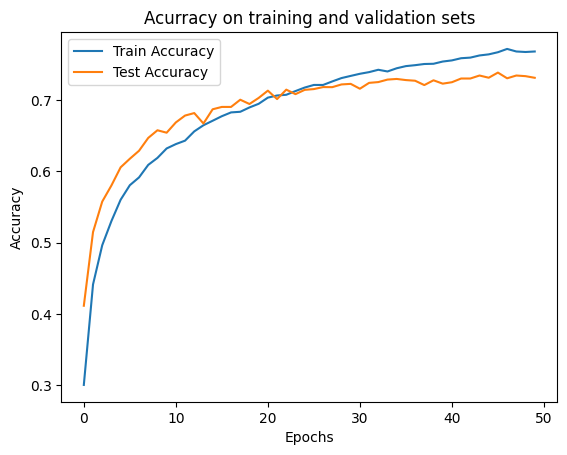

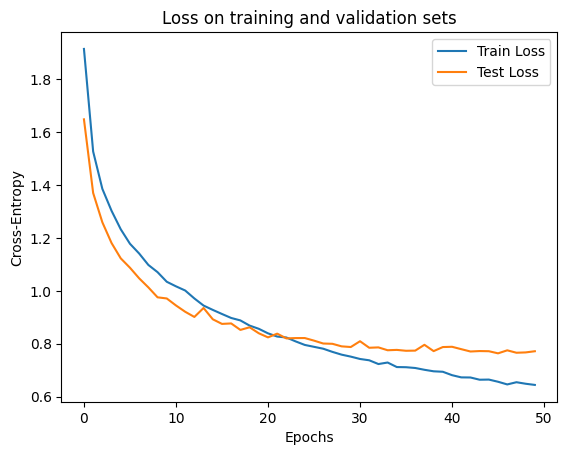

313/313 [==============================] - 4s 12ms/step - loss: 0.7819 - f1Score: 0.7247 - accuracy: 0.7324
Test accuracy: 0.7324
Test F1 Score: 0.7247


In [ ]:
ModelCNN.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=[f1Score , 'accuracy'])

start = time.time()

#Train model
history = ModelCNN.fit(XTrain, yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


score = ModelCNN.evaluate(XTest, yTest)
print('Test accuracy: {:.4f}'.format(score[2]))
print('Test F1 Score: {:.4f}'.format(score[1]))

## **3rd CNN Model with double convolutional Layer**


In [ ]:
# Create the model
ModelCNN3 = models.Sequential()

initializer = tensorflow.keras.initializers.HeNormal()

ModelCNN3.add(layers.Conv2D(filters=32, kernel_size=(2,2), padding="same", activation='relu',input_shape=(32,32,3),
                            kernel_initializer=initializer))
ModelCNN3.add(layers.Conv2D(filters=32, kernel_size=(2,2), padding="same", activation='relu',
                            kernel_initializer=initializer))

#ModelCNN.add(layers.BatchNormalization())
ModelCNN3.add(layers.MaxPooling2D(pool_size=(2,2)))
ModelCNN3.add(Dropout(0.2))


ModelCNN3.add(layers.Conv2D(filters=64, kernel_size=(2,2), padding="same", activation='relu',
                            kernel_initializer=initializer))
ModelCNN3.add(layers.Conv2D(filters=64, kernel_size=(2,2), padding="same", activation='relu',
                            kernel_initializer=initializer))

#ModelCNN.add(layers.BatchNormalization())
ModelCNN3.add(layers.MaxPooling2D(pool_size=(2,2)))
ModelCNN3.add(Dropout(0.2))

ModelCNN3.add(layers.Conv2D(filters=128, kernel_size=(2,2), padding="same", activation='relu',
                            kernel_initializer=initializer))
ModelCNN3.add(layers.Conv2D(filters=128, kernel_size=(2,2), padding="same", activation='relu',
                            kernel_initializer=initializer))

#ModelCNN.add(layers.BatchNormalization())
ModelCNN3.add(layers.MaxPooling2D(pool_size=(2,2)))
ModelCNN3.add(Dropout(0.2))

ModelCNN3.add(layers.Flatten())
ModelCNN3.add(layers.Dense(512, activation='relu', kernel_initializer=initializer))

#ModelCNN.add(layers.BatchNormalization())
ModelCNN3.add(Dropout(0.2))

ModelCNN3.add(layers.Dense(numClasses, activation='softmax'))

ModelCNN3.summary()

In [ ]:
ModelCNN3.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=[f1Score , 'accuracy'])

start = time.time()

#Train model
history = ModelCNN3.fit(XTrain, yTrain, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

end = time.time()
print("Training time: {:.3f} seconds\n".format(end-start))

plt.figure()
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Test Accuracy')
plt.title('Acurracy on training and validation sets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Loss on training and validation sets')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


score = ModelCNN3.evaluate(XTest, yTest)
print('Test accuracy: {:.4f}'.format(score[2]))
print('Test F1 Score: {:.4f}'.format(score[1]))

#Predictions
prediction = ModelCNN3.predict(XTest, verbose=1)
yPred = np.argmax(prediction, axis=1) #get predicted class
labels = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

print('Printing examples of correct classification:')
printed = 0
fig = plt.figure(figsize=(4,4))
for i in range (0, yTest.shape[0]):
    if yTestLabels[i] == yPred[i]:
       ax = fig.add_subplot(2, 2, printed + 1, xticks=[], yticks=[])
       ax.title.set_text(labels[yPred[i]])
       ax.imshow((XTest[i, :]*XTrainNotScaled.max()).astype(int))
       printed += 1
    if printed == 4:
       printed = 0
       break
plt.show()

print('Printing examples of false classification:')
fig2 = plt.figure(figsize=(4,4))
for i in range (0, yTest.shape[0]):
    if yTestLabels[i] !=  yPred[i]:
     ax2 = fig2.add_subplot(2, 2, printed + 1, xticks=[], yticks=[])
     ax2.title.set_text(labels[yPred[i]])
     ax2.imshow((XTest[i, :]*XTrainNotScaled.max()).astype(int))
     printed += 1
     if printed == 4:
        break
plt.show()

#Create and display confusion matrix
M = confusion_matrix(yTestLabels, yPred)

disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show

#accuracy, precision, recall and f1-score
print(classification_report(yTestLabels, yPred))